In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from analysis.dataset.june_dataset import JuNEDataset
from analysis.metrics.metrics_transtions import TransitionMetrics


def read_config(config_path: Path = Path("data_config.yaml")) -> dict:
    with config_path.open("r") as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError:
            return {}


config = read_config()


In [2]:
df_hack = pd.read_csv(config.get("dataset_path"), index_col=0)
df_labels = pd.read_csv(config.get("label_mapping_path"), index_col=0)
df_hack = df_hack.merge(df_labels, on='action_id')

df_hack.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,NaN,NaN,NaN,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",NaN,student_7,False,NaN
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions


In [3]:
june = JuNEDataset(df_hack)
june.prepare_dataset()
june.df['cell_label'] = june.df['cell_label'].apply(lambda x: x + ',' if x else x)

june.df.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label,task
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",None,student_7,False,,task1
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,"helper_functions,",task1
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,"helper_functions,",task1
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,"helper_functions,",task1
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,"helper_functions,",task1


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

labels = june.df.cell_label.fillna("").apply(lambda x: x.split(",")[:-1])

mlb = MultiLabelBinarizer()

onehot_labels = pd.DataFrame(
    mlb.fit_transform(labels),
    columns=mlb.classes_,
    index=labels.index
)
onehot_labels.head()


,comment_only,data_exploration,data_preprocessing,evaluation,helper_functions,load_data,modelling,prediction,result_visualization,save_results
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


In [5]:
labels = [
    'comment_only', 'helper_functions', 'load_data', 'data_exploration',
    'data_preprocessing', 'result_visualization', 'save_results', 'modelling', 'evaluation',
    'prediction'
]

df_with_onehot = pd.concat([june.df, onehot_labels], axis=1)
label_count_per_cell = df_with_onehot[labels].sum(axis=1).values
df_with_single_label = df_with_onehot[label_count_per_cell == 1]
df_with_single_label['cell_label'] = df_with_single_label.cell_label.fillna("").apply(
    lambda x: x.strip().split(',')[0]
)
df_with_single_label.head()


/var/folders/3y/nyxrc7xj5fsfcj6kx385np600000gp/T/ipykernel_33118/978031038.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_single_label['cell_label'] = df_with_single_label.cell_label.fillna("").apply(


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,...,comment_only,data_exploration,data_preprocessing,evaluation,helper_functions,load_data,modelling,prediction,result_visualization,save_results
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,...,0,0,0,0,1,0,0,0,0,0
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,...,0,0,0,0,1,0,0,0,0,0
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,...,0,0,0,0,1,0,0,0,0,0
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,...,0,0,0,0,1,0,0,0,0,0
5,5,2023-05-06 10:33:01.263,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,...,0,0,0,0,1,0,0,0,0,0


In [6]:
processor = TransitionMetrics()
all_transitions = processor.calculate_metrics(df_with_single_label)
all_transitions.head()


100%|██████████| 31/31 [00:00<00:00, 5334.51it/s]


,kernel_id,cell_idx_from,cell_num_from,cell_source_from,cell_idx_to,cell_num_to,cell_source_to,cell_label_from,cell_label_to,inner_transition,type,event_from,event_to
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,e139884774504ae997d7e38e6be6da88,0.0,# # Do not forget to check if your notebook lo...,a47800e62cbe40c1ad4003b2879f5f03,1.0,!pip install pandas\n,helper_functions,helper_functions,False,execution_transition,NaN,NaN
1,0033f76c-6179-4fb4-a9ce-79112a52b51c,a47800e62cbe40c1ad4003b2879f5f03,1.0,!pip install pandas\n,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,!pip install sklearn,helper_functions,helper_functions,False,execution_transition,NaN,NaN
2,0033f76c-6179-4fb4-a9ce-79112a52b51c,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,!pip install sklearn,da13661b37a24a319d339a52b96bd0c7,3.0,!pip install catboost\n!pip install xgboost,helper_functions,helper_functions,False,execution_transition,NaN,NaN
3,0033f76c-6179-4fb4-a9ce-79112a52b51c,da13661b37a24a319d339a52b96bd0c7,3.0,!pip install catboost\n!pip install xgboost,fcbfe01318394ee78c110d6efe344931,4.0,import pandas as pd\nimport sklearn\nimport ca...,helper_functions,helper_functions,False,execution_transition,NaN,NaN
4,0033f76c-6179-4fb4-a9ce-79112a52b51c,fcbfe01318394ee78c110d6efe344931,4.0,import pandas as pd\nimport sklearn\nimport ca...,8fd58da2205544c1a978c43701cd5678,0.0,# # Do not forget to check if your notebook lo...,helper_functions,helper_functions,False,execution_transition,NaN,NaN


In [7]:
execution_transitions = all_transitions[all_transitions.type == "execution_transition"]
execution_transitions.shape


(7958, 13)

In [8]:
all_transitions_merged = execution_transitions.merge(
    june.df[['task', 'kernel_id', 'expert']].drop_duplicates(subset=['task', 'kernel_id'], keep='last'),
    on='kernel_id'
)
all_transitions_merged.head()


,kernel_id,cell_idx_from,cell_num_from,cell_source_from,cell_idx_to,cell_num_to,cell_source_to,cell_label_from,cell_label_to,inner_transition,type,event_from,event_to,task,expert
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,e139884774504ae997d7e38e6be6da88,0.0,# # Do not forget to check if your notebook lo...,a47800e62cbe40c1ad4003b2879f5f03,1.0,!pip install pandas\n,helper_functions,helper_functions,False,execution_transition,NaN,NaN,task1,False
1,0033f76c-6179-4fb4-a9ce-79112a52b51c,a47800e62cbe40c1ad4003b2879f5f03,1.0,!pip install pandas\n,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,!pip install sklearn,helper_functions,helper_functions,False,execution_transition,NaN,NaN,task1,False
2,0033f76c-6179-4fb4-a9ce-79112a52b51c,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,!pip install sklearn,da13661b37a24a319d339a52b96bd0c7,3.0,!pip install catboost\n!pip install xgboost,helper_functions,helper_functions,False,execution_transition,NaN,NaN,task1,False
3,0033f76c-6179-4fb4-a9ce-79112a52b51c,da13661b37a24a319d339a52b96bd0c7,3.0,!pip install catboost\n!pip install xgboost,fcbfe01318394ee78c110d6efe344931,4.0,import pandas as pd\nimport sklearn\nimport ca...,helper_functions,helper_functions,False,execution_transition,NaN,NaN,task1,False
4,0033f76c-6179-4fb4-a9ce-79112a52b51c,fcbfe01318394ee78c110d6efe344931,4.0,import pandas as pd\nimport sklearn\nimport ca...,8fd58da2205544c1a978c43701cd5678,0.0,# # Do not forget to check if your notebook lo...,helper_functions,helper_functions,False,execution_transition,NaN,NaN,task1,False


In [9]:
grouped_transitions = all_transitions_merged.groupby(['cell_label_from']) \
    .cell_label_to.value_counts().reset_index().rename({"count": "transitions_count"}, axis=1)

grouped_transitions['probability'] = grouped_transitions.transitions_count / grouped_transitions.transitions_count.sum()

grouped_transitions.head()


,cell_label_from,cell_label_to,transitions_count,probability
0,comment_only,comment_only,400,0.050264
1,comment_only,data_preprocessing,235,0.029530
2,comment_only,data_exploration,228,0.028650
3,comment_only,helper_functions,126,0.015833
4,comment_only,modelling,38,0.004775


In [10]:
transitions_matrix = grouped_transitions.pivot(
    index='cell_label_from', columns='cell_label_to', values='probability'
).fillna(0)
transitions_matrix


cell_label_to,comment_only,data_exploration,data_preprocessing,evaluation,helper_functions,load_data,modelling,prediction,result_visualization,save_results
cell_label_from,,,,,,,,,,
comment_only,0.050264,0.028650,0.029530,0.000377,0.015833,0.003141,0.004775,0.001005,0.001759,0.000126
data_exploration,0.025760,0.176175,0.049636,0.000126,0.022242,0.004775,0.003770,0.000880,0.010304,0.000754
data_preprocessing,0.033174,0.047248,0.166122,0.000000,0.016084,0.004775,0.004524,0.000377,0.002388,0.000000
evaluation,0.000126,0.000126,0.000126,0.000377,0.000880,0.000000,0.000126,0.000126,0.000000,0.000000
helper_functions,0.009424,0.020734,0.012440,0.000628,0.077532,0.014074,0.004272,0.003644,0.002639,0.000000
load_data,0.008042,0.008419,0.009173,0.000000,0.003267,0.016713,0.000000,0.000126,0.000126,0.000000
modelling,0.003016,0.001382,0.002765,0.000377,0.002262,0.001508,0.022996,0.011184,0.000754,0.000126
prediction,0.004398,0.001885,0.003016,0.000126,0.002262,0.000251,0.004775,0.007163,0.000126,0.000000
result_visualization,0.001508,0.010681,0.002388,0.000000,0.002011,0.000126,0.001005,0.000000,0.013320,0.000000


In [11]:
def plot_transitions_matrix(matrix, fig_ax=None):
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(12, 9))
    else:
        fig, ax = fig_ax

    full_matrix = pd.DataFrame(columns=labels, index=labels)
    full_matrix.loc[labels, labels] = matrix
    full_matrix = full_matrix.fillna(-1)
    mask = np.where(full_matrix == -1, True, False)


    cmap = sns.color_palette("Blues", as_cmap=True)
    cmap.set_bad(color='grey', alpha=0.1)

    ax = sns.heatmap(
        full_matrix.fillna(-1).round(3),
        annot=True,
        fmt="", cmap=cmap, mask=mask,
        linewidths=1,
        square=True, robust=True, ax=ax
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=90,
        horizontalalignment='right'
    )
    return fig, ax


In [12]:
task, expert = 'task2', True
grouped_transitions = all_transitions_merged\
    .groupby(['task', 'expert']).get_group((task, expert))\
    .groupby(['cell_label_from']).cell_label_to.value_counts()\
    .reset_index().rename({"count": "transitions_count"}, axis=1)

grouped_transitions['probability'] = grouped_transitions.transitions_count / grouped_transitions.transitions_count.sum()

transitions_matrix = grouped_transitions.pivot(
    index='cell_label_from', columns='cell_label_to', values='probability'
).fillna(0)
transitions_matrix


cell_label_to,comment_only,data_exploration,data_preprocessing,evaluation,helper_functions,load_data,modelling,prediction,result_visualization,save_results
cell_label_from,,,,,,,,,,
comment_only,0.045149,0.034777,0.025625,0.001830,0.027456,0.002441,0.018914,0.003661,0.000610,0.00061
data_exploration,0.024405,0.103112,0.019524,0.000610,0.027456,0.003051,0.015253,0.000610,0.010372,0.00061
data_preprocessing,0.028676,0.014033,0.062233,0.000000,0.031727,0.000610,0.014033,0.001220,0.000000,0.00000
evaluation,0.000610,0.000610,0.000610,0.001830,0.004271,0.000000,0.000610,0.000610,0.000000,0.00000
helper_functions,0.018914,0.034777,0.016473,0.003051,0.076266,0.010982,0.010372,0.015253,0.002441,0.00000
load_data,0.010982,0.000610,0.002441,0.000000,0.006711,0.000610,0.000000,0.000000,0.000000,0.00000
modelling,0.010372,0.002441,0.010372,0.001830,0.003661,0.003051,0.061013,0.049420,0.001830,0.00000
prediction,0.019524,0.006101,0.014033,0.000610,0.007322,0.000000,0.021965,0.026236,0.000000,0.00000
result_visualization,0.002441,0.008542,0.001220,0.000000,0.001830,0.000000,0.001220,0.000000,0.006711,0.00000


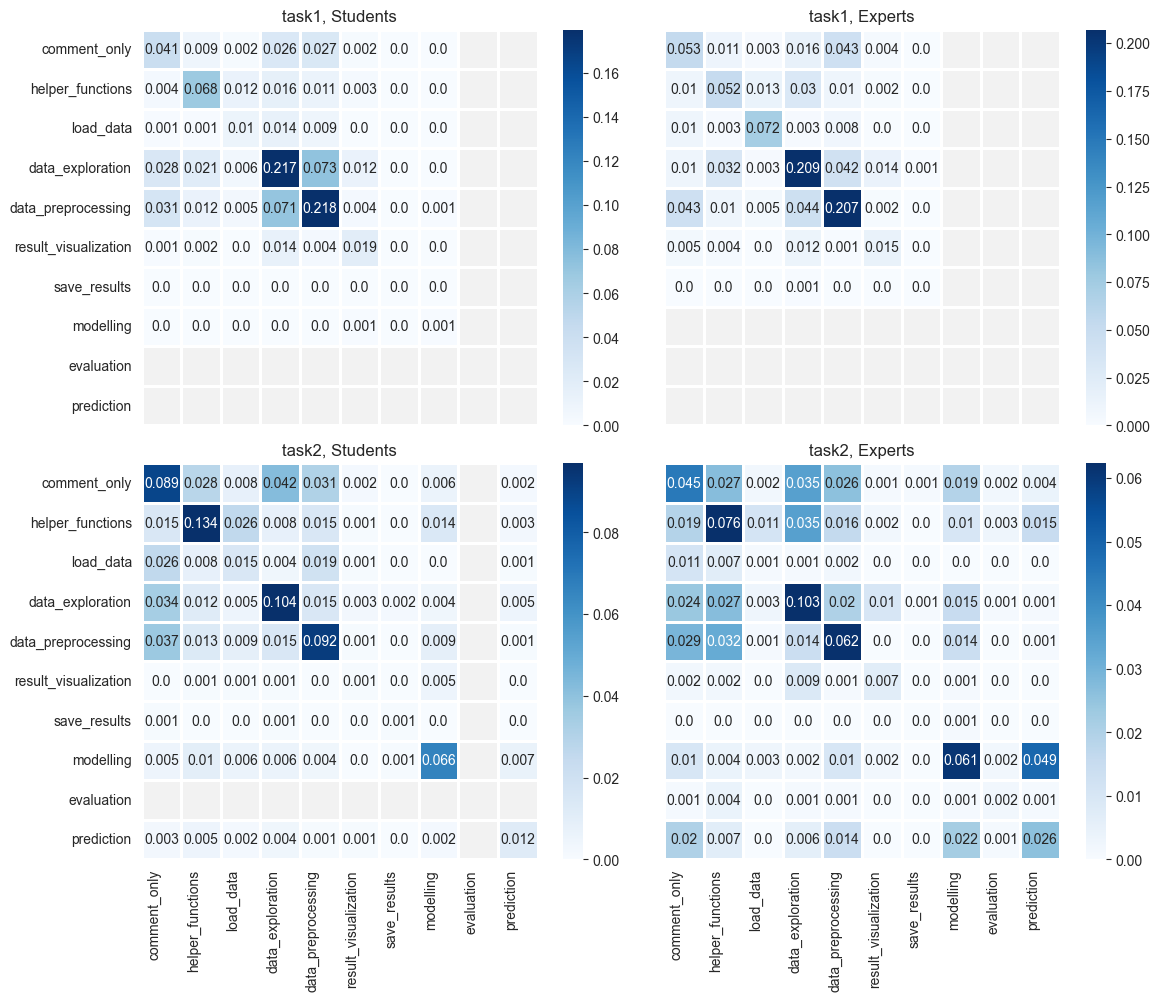

In [16]:
sns.set_style("whitegrid", {'axes.grid' : False})

fig_all, ax_all = plt.subplots(2, 2, figsize=(12, 10))

for i, task in enumerate(['task1', 'task2']):
    for j, expert in enumerate([False, True]):
        grouped_transitions = all_transitions_merged\
            .groupby(['task', 'expert']).get_group((task, expert))\
            .groupby(['cell_label_from']).cell_label_to.value_counts()\
            .reset_index().rename({"count": "transitions_count"}, axis=1)

        grouped_transitions['probability'] = grouped_transitions.transitions_count / grouped_transitions.transitions_count.sum()

        transitions_matrix = grouped_transitions.pivot(
            index='cell_label_from', columns='cell_label_to', values='probability'
        ).fillna(0)
        ax_all[i][j].set_title(f"{task}, {'Experts' if expert else 'Students'}")
        fig_all, ax_all[i][j] = plot_transitions_matrix(transitions_matrix, (fig_all, ax_all[i][j]))

ax_all[0, 0].set_xticks([])
ax_all[0, 1].set_xticks([])
ax_all[0, 1].set_yticks([])
ax_all[1, 1].set_yticks([])
plt.tight_layout()

plt.savefig(f'figures/transitions/transitions_matrix.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [17]:
transitions_matrix.sum().sum()


1.0

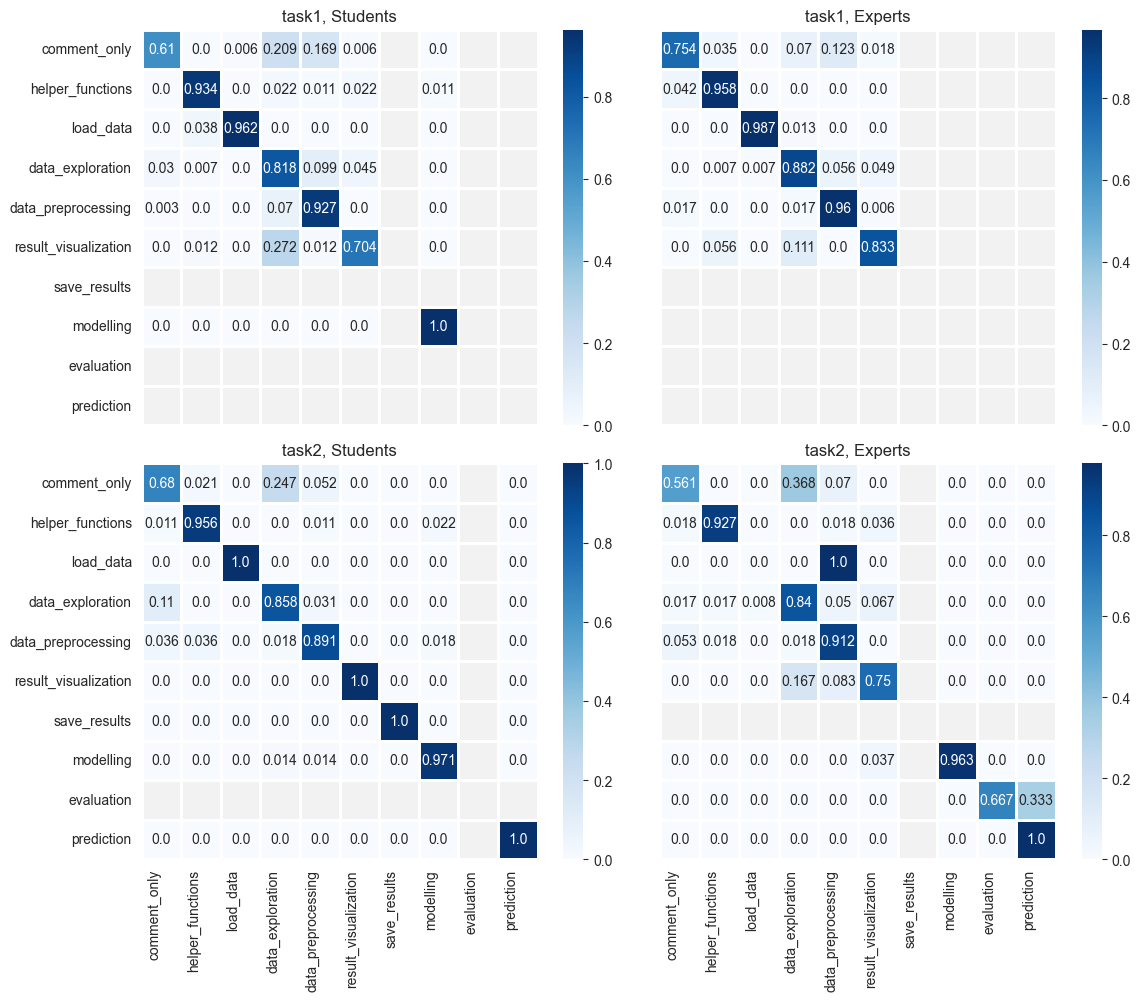

In [20]:
fig_all, ax_all = plt.subplots(2, 2, figsize=(12, 10))

for i, task in enumerate(['task1', 'task2']):
    for j, expert in enumerate([False, True]):
        grouped_transitions = all_transitions_merged.groupby("inner_transition").get_group(True)\
            .groupby(['task', 'expert']).get_group((task, expert))\
            .groupby(['cell_label_from']).cell_label_to.value_counts(normalize=True)\
            .reset_index().rename({"proportion": "probability"}, axis=1)

        transitions_matrix = grouped_transitions.pivot(
            index='cell_label_from', columns='cell_label_to', values='probability'
        ).fillna(0)
        ax_all[i][j].set_title(f"{task}, {'Experts' if expert else 'Students'}")
        fig_all, ax_all[i][j] = plot_transitions_matrix(transitions_matrix, (fig_all, ax_all[i][j]))

ax_all[0, 0].set_xticks([])
ax_all[0, 1].set_xticks([])
ax_all[0, 1].set_yticks([])
ax_all[1, 1].set_yticks([])

plt.tight_layout()

plt.savefig(f'figures/transitions/inner_transitions_matrix.pdf', dpi=300, bbox_inches='tight')

plt.show()
